# Data-driven discovery of chemical reaction networks: M1 Graph Recovery

## Introduction

In this notebook we illustrate the data-driven graph recovery of a closed chemical reaction network system, the M1 model.

This mechanism is given by

\begin{equation} 
    \overbrace{
        \begin{bmatrix}
        \color{purple}{\dot{x}_\text{A}} \\ 
        \color{teal}{\dot{x}_\text{P}} \\ 
        \color{RoyalBlue}{\dot{x}_\text{cat}} \\ 
        \color{DarkOrchid}{\dot{x}_\text{catA}} \\ 
        \end{bmatrix}}^{\dot{\mathbf{x}}(t)} = 
\overbrace{\begin{bmatrix} 
0 & 0 & 0 &      k_{-1}   & 0 & 0 & 0 & -k_{1} &    0    & 0 & 0 & 0 & 0 & 0  \\ 
0 & 0 & 0 &      k_{2}    & 0 & 0 & 0 &   0    & -k_{-2} & 0 & 0 & 0 & 0 & 0  \\ 
0 & 0 & 0 & k_{-1}+k_{2}  & 0 & 0 & 0 & -k_{1} & -k_{-2} & 0 & 0 & 0 & 0 & 0  \\ 
0 & 0 & 0 & -k_{-1}-k_{2} & 0 & 0 & 0 & k_{1}  & k_{-2}  & 0 & 0 & 0 & 0 & 0   \end{bmatrix} }^{\mathbf{C}} \overbrace{\begin{bmatrix}
\color{purple}{{x}_\text{A}} \\ 
\color{teal}{{x}_\text{P}}\\ 
\color{RoyalBlue}{{x}_\text{cat}}  \\ 
\color{DarkOrchid}{{x}_\text{catA}}\\ 
\color{purple}{{x}_\text{A}^{2}} \\ 
\color{teal}{{x}_\text{P}}\color{purple}{{x}_\text{A}} \\ 
\color{teal}{{x}_\text{P}^{2}} \\ 
\color{RoyalBlue}{{x}_\text{cat}}  \color{purple}{{x}_\text{A}} \\ 
\color{RoyalBlue}{{x}_\text{cat}}  \color{teal}{{x}_\text{P}}\\ 
\color{RoyalBlue}{{x}_\text{cat}^{2}}  \\
\color{DarkOrchid}{{x}_\text{catA}} \color{purple}{{x}_\text{A}} \\  
\color{DarkOrchid}{{x}_\text{catA}} \color{teal}{{x}_\text{P}}\\
\color{DarkOrchid}{{x}_\text{catA}} \color{RoyalBlue}{{x}_\text{cat}}  \\
\color{DarkOrchid}{{x}_\text{catA}^{2}}
\end{bmatrix}}^{\mathbf{d}(t)} \,,
\end{equation}

where $\mathbf{x}(t)$ is the vector of concentrations with one entry per chemical species of the system (for M1 we have 4 species) and $\mathbf{d}(t)$ a dictionary vector of second order on $\mathbf{x}(t)$ (i.e., for M1, $\mathbf{d}(t)$ contains all possible linear and quadratic monomials of the concentrations $x_{\alpha}(t)$).

The coefficient matrix $\mathbf{C}$ can be factored as the product of two matrices $\mathbf{K}$ and $\mathbf{Q}$ s.t.

- $\mathbf{Q}\in \mathbb{R}^{M\times O}$ is the stoichiometry matrix of the monomials in $\mathbf{d}(t)$. Each entry $\mathbf{Q}_{\alpha,l}$ represents the order of concentration $x_{\alpha}$ in the $l$-th entry of $\mathbf{d}(t)$ has. 

- $\mathbf{K} \in \mathbb{R}^{O \times O}$ is the Kirchhoff (Laplacian) matrix of the network, satisfying: 

    - every column sums to zero, i.e., $ \sum_{j=1}^{M} \mathbf{K}[i,j] = 0 \ \forall \ i=1,2,\ldots,O \,;$

    - every diagonal entry is non-positive, i.e., $ \mathbf{K}[i,j] \leq 0 \ \forall \ i = j \,;$

    - every off-diagonal term is non-negative, i.e., $ \mathbf{K}[i,j] \geq 0 \forall i \neq j$, and $\mathbf{K}[i,i] < 0 \,;$

    - The entries $\mathbf{K}[i,j]$ are the kinetic constant of the reaction $q_{j} \xrightarrow{} q_{i}$.
    
## Graph recovery

Using measurements from the concentrations our objective is to recover the graph matrix of the mechanism.

## Import modules and auxiliary functions

In [1]:
import os
import mechanisms as mech
import graphsindy as gs
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import sympy as sp

# Array of RGB colors in 0-255 range
rgb_colours = [(152, 114, 132),
              (112, 169, 161), 
              (166, 52, 70),
              (216, 30, 91),
              (20, 50, 60),
              (0, 0, 0)]

# Convert to 0-1 range
colours = [(r/255, g/255, b/255) for r, g, b in rgb_colours]

node_colours =  {'$x_{cat}$'      : np.array(colours[2]),
                 '$x_{catA}$'     : np.array(colours[3]),
                 '$x_{cat}x_{A}$' : np.array(colours[3]+colours[0]),
                 '$x_{cat}x_{P}$' : np.array(colours[3]+colours[1])}

def symbolic_equations(A, x):
    """
    ----------
    Computes a symbolic representation of an ODE system A*x
    
    ----------
    Parameters 
    ----------
        A : np.ndarray of shape (M, N) with float entries
        x : np.ndarray of shape (N,) with variable names as strings (e.g. ["x_1","x_2",...])
        
    ----------
    Returns 
    ----------
        list of sympy expressions representing A * x
    """
    # Convert string variable names to sympy symbols
    sym_vars = sp.symbols(' '.join(x))

    # Create a sympy Matrix version of A and x
    A_sym = sp.Matrix(np.round(A,3))
    x_sym = sp.Matrix(sym_vars)

    # Compute the symbolic product
    y_sym = A_sym * x_sym

    # Pretty-print each resulting equation
    for i, expr in enumerate(y_sym):
        print(f"Equation {i}:")
        sp.pprint(expr, use_unicode=True)

    return y_sym

# Define a helper for blending two RGB triplets
def blend(c1, c2, w1=0.5, w2=0.5):
    c1 = np.array(c1)
    c2 = np.array(c2)
    mixed = w1*c1 + w2*c2
    return tuple(np.clip(mixed, 0, 1))  # keep values in [0, 1]

## Random seed for reproducibility

In [2]:
rng  = np.random.default_rng()
seed = rng.integers(1,10000)
#seed = 1589
print(f'Run seed:\n{seed}')
rng  = np.random.default_rng(seed)

Run seed:
9006


## Model and simulation parameters

In [3]:
# Choose model
model = 'M1'

# Min-max values for reaction rates
min_k, max_k = 5e-2, 1.0

# Choose a set of 4 kinetic constants uniformly from the interval [min_k,max_k]
constants = rng.uniform(min_k, max_k, size=4)

# Create instance of the model with the randomly selected constants
Model = mech.M1(constants)

# Set number of experiments to be realised
w = 6

print(f'Run kinetic rates:\n{constants}')
M, N = Model.M, Model.N
X_labels = Model.labels

# Construct ground-truth coefficient and graph matrix for benchmarking
C_ex  = Model.ExactCoeffMatrix()
K_ex  = Model.ExactKirchhoffMatrix()

# Choose a set of w sets of initial values to be simulated
initial_values = rng.uniform(0,1, size=(w, M))

rounded_values = np.round(initial_values, 3)
print(f'Run initial values:\n{rounded_values}')

# Simulation Parameters
tmax, npts = 20, 30                                     # Integration interval and No. of data points
t_eval = np.linspace(0,tmax,npts)                         # Equispaced data points
rtol = 1e-10                                              # Solve_IVP Tolerance (explore later)

# Noise parameters
# on
#noise_bool = "on"
#noise = '1e-2'
#instrument_noise = float(noise)
#print(f'Noise intensity:\n{instrument_noise}')

# off
noise_bool = "off"
noise      = 0.0

# STLS Threshold
threshold = np.min(constants[constants != 0])/2
print(f'STLS threshold:\n{threshold}')

Run kinetic rates:
[0.40043981 0.32970051 0.6228214  0.30643874]
Run initial values:
[[0.314 0.045 0.635 0.921]
 [0.289 0.32  0.731 0.426]
 [0.555 0.895 0.418 0.732]
 [0.982 0.372 0.84  0.207]
 [0.13  0.188 0.344 0.22 ]
 [0.365 0.44  0.159 0.054]]
STLS threshold:
0.15321937052068568


In [4]:
# Create/open directory for saving graph images
if noise_bool == "off":
    # Parent directory — shared by all runs of same model
    parent_folder = f"{model}_mechgrap_noise-{noise_bool}"
    os.makedirs(parent_folder, exist_ok=True)

    # Individual run directory
    run_folder = f"tmax-{tmax}_npts-{npts}"
    graphs_folder = os.path.join(parent_folder, run_folder)
    os.makedirs(graphs_folder, exist_ok=True)

if noise_bool == "on":
    # Parent directory — shared by all runs of same model
    parent_folder = f"{model}_mechgrap_noise-{noise_bool}"
    os.makedirs(parent_folder, exist_ok=True)
    
    # Individual run directory
    run_folder = f"tmax-{tmax}_npts-{npts}"
    graphs_folder = os.path.join(parent_folder, run_folder)
    os.makedirs(graphs_folder, exist_ok=True)

## Simulation

In [5]:
# Simulation
X = np.zeros((M,0)) 
T     = np.zeros((0,))
for i in range(w):
    sol   = integrate.solve_ivp(fun=lambda t,U: gs.matrix_ODE(t,U,C_ex), t_span=t_eval[[0,-1]], 
                                y0=initial_values[i], t_eval=t_eval, rtol=rtol)
    
    # Add Gaussian noise to the simulation data (simultates measurement error)
    if noise_bool == "on":
        for j in range(M):
            xi       = rng.normal(0, instrument_noise, size = sol.y[j].shape[0])
            sol.y[j] += xi

    X = np.hstack((X, sol.y))
    T = np.hstack((T, sol.t))

## Piecewise interpolation and numerical integration/differentiation

In [6]:
# Build dictionary matrix
D, D_labels = gs.build_dictionary(X_labels, X)
rankD  = np.linalg.matrix_rank(D)

# Verify that dictionary is of full row rank (i.e. that we have realised the sufficient number of experiments)
if rankD == D.shape[0]:
    print(f'Dictionary of full row rank ({rankD})')

# Construct the integration and differentiation operator matrices
spline_deg  = 3
spline_type = 'not-a-knot'
J,L         = gs.build_int_dif_matrix(t_eval, w, spline_deg, spline_type)

# Construct IVP matrix
IVP = gs.build_ivp_matrix(npts,X)

# Approximate the integral of dictionary matrix 
D_int  = D@J
rankDJ = np.linalg.matrix_rank(D_int)

# Verify that integrated dictionary remains of full row rank.
if rankDJ == D_int.shape[0]:
    print(f'Integrated dictionary of full row rank ({rankDJ})')

    
X_int = C_ex@D_int   # Integral Formulation (Approximated from the data)
X_0   = X-IVP        # Integral formulation left-hand side Y_int_ex = CDK (Exact from the data)

Dictionary of full row rank (14)
Integrated dictionary of full row rank (14)


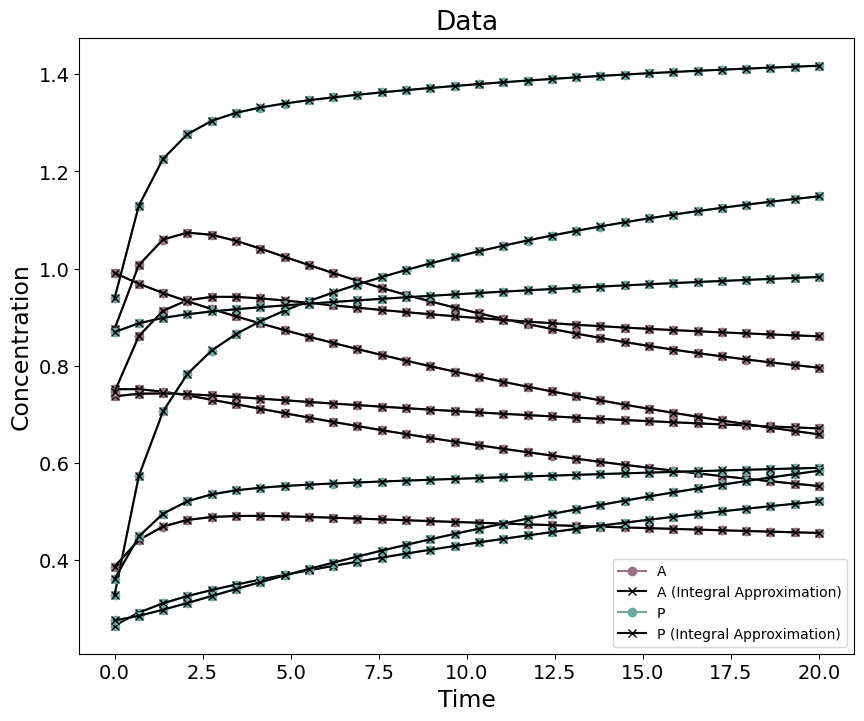

In [40]:
plt.rcParams["figure.figsize"] = (10,8)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
for i in range(2):
    for j in range(w):
        if j == 0:
            ax1.plot(T[:npts], X[i][:npts].T, '-o', label=D_labels[i], color=colours[i])
            ax1.plot(T[:npts], IVP[i][:npts].T + X_int[i][:npts].T,   'k-x', label=D_labels[i] + ' (Integral Approximation)')
        else:
            ax1.plot(T[:npts], X[i][j*npts:(j+1)*npts].T, '-o', color=colours[i])
            ax1.plot(T[:npts], IVP[i][j*npts:(j+1)*npts].T + X_int[i][j*npts:(j+1)*npts].T, 'k-x')
            
plt.legend(fontsize=10)
plt.title('Data', fontsize = 19)
plt.ylabel('Concentration', fontsize = 17)
plt.xlabel('Time', fontsize = 17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

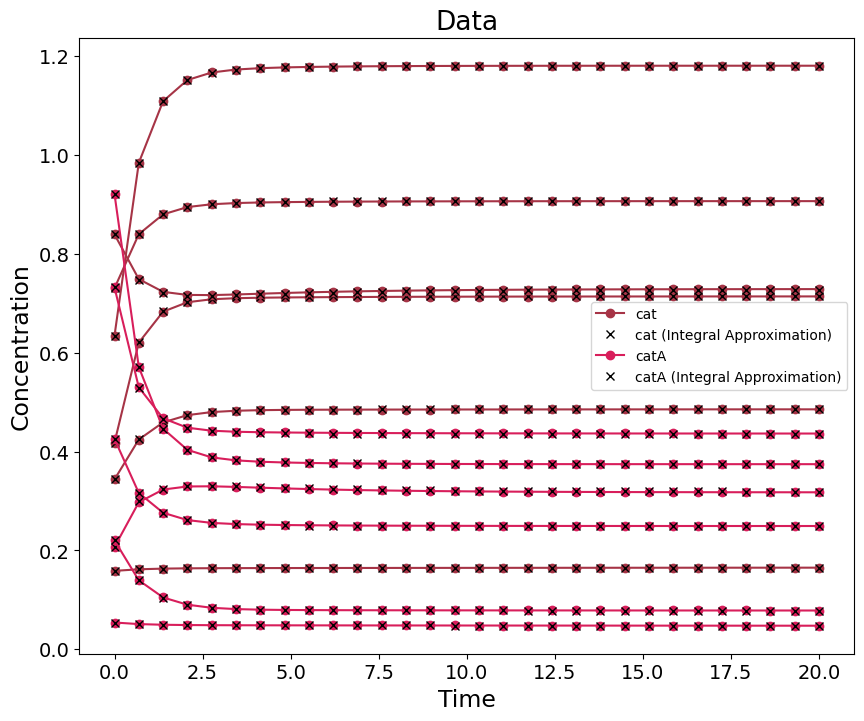

In [7]:
plt.rcParams["figure.figsize"] = (10,8)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
for i in range(M-2):
    for j in range(w):
        if j == 0:
            ax1.plot(T[:npts], X[i+2][:npts].T, '-o', label=D_labels[i+2], color=colours[i+2])
            ax1.plot(T[:npts], IVP[i+2][:npts].T + X_int[i+2][:npts].T,   'kx', label=D_labels[i+2] + ' (Integral Approximation)')
        else:
            ax1.plot(T[:npts], X[i+2][j*npts:(j+1)*npts].T, '-o', color=colours[i+2])
            ax1.plot(T[:npts], IVP[i+2][j*npts:(j+1)*npts].T + X_int[i+2][j*npts:(j+1)*npts].T, 'kx')
            
plt.legend(fontsize=10)
plt.title('Data', fontsize = 19)
plt.ylabel('Concentration', fontsize = 17)
plt.xlabel('Time', fontsize = 17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Model recovery

### ODE recovery with SINDy

We use SINDy with STLS under the integral and differential formulations to find approximated coefficient matrices $C_{\mathrm{dif}}$ and $C_{\mathrm{int}}$ that recover the M1 Model ODE system with which we generated the training data.

We print the 2-norm of the difference between the ground-truth $C$ and the obtained approximation.

In [8]:
C_dif = gs.itls(D,X@L, threshold)
C_int = gs.itls(D_int,X_0, threshold)

print(f'2-norm of error ΔC for integral formulation:     {np.linalg.norm(C_ex - C_int, 2)}')
print(f'2-norm of error ΔC for differential formulation: {np.linalg.norm(C_ex - C_dif, 2)}')

2-norm of error ΔC for integral formulation:     0.002769204756381448
2-norm of error ΔC for differential formulation: 0.08700383834318308


### Graph recovery

After we approximated a coefficient matrix using SINDy, we realise our post-processing step to extract a chemically-meaningful mechanism from this. 

We first reduce our approximated $\mathbf{C}$ by removing all its inactive columns, use this reduction to construct an stoichiometry matrix $\mathbf{Q}$, and then we solve the Kirchhoff discovery problem to find the graph.

In [9]:
C_int_red, Q, Q_labels = gs.reduce_model(C_int,M,N,D_labels)

C_dif_red, QQ, QQ_labels = gs.reduce_model(C_dif,M,N,D_labels)

C_ex_red, _ = gs.remove_zero_columns(C_ex)

print("The reduced identified coefficient matrix is:")
print(np.round(C_int_red,2))
print('\n')
print("The reduced identified coefficient matrix is:")
print(np.round(C_dif_red,2))
print('\n')
print("The reduced exact coefficient matrix is:")
print(np.round(C_ex_red,2))

The reduced identified coefficient matrix is:
[[ 0.33 -0.4   0.  ]
 [ 0.62  0.   -0.31]
 [ 0.95 -0.4  -0.31]
 [-0.95  0.4   0.31]]


The reduced identified coefficient matrix is:
[[ 0.31 -0.38  0.  ]
 [ 0.6   0.   -0.3 ]
 [ 0.9  -0.37 -0.29]
 [-0.9   0.37  0.29]]


The reduced exact coefficient matrix is:
[[ 0.33 -0.4   0.  ]
 [ 0.62  0.   -0.31]
 [ 0.95 -0.4  -0.31]
 [-0.95  0.4   0.31]]


The Kirchhoff matrix found by optimization is:
['catA', 'cat*A', 'cat*P']
[[-0.95168196  0.39912361  0.30666244]
 [ 0.32857644 -0.39937579  0.        ]
 [ 0.62310552  0.         -0.30674812]]


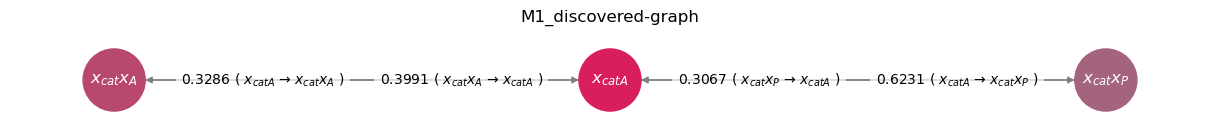

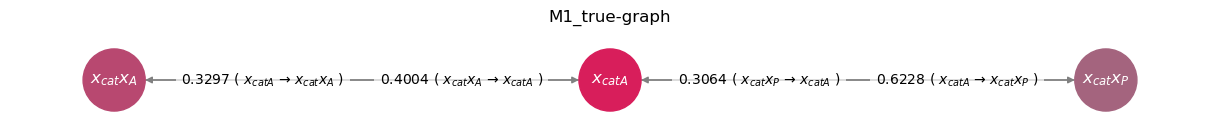

In [10]:
K_opt = gs.solve_kirchhoff(Q, C_int_red)
K_opt = np.where(np.abs(K_opt) >= threshold, K_opt, 0)

print("The Kirchhoff matrix found by optimization is:")
print(Q_labels)
print(K_opt)

if model == 'M1':
    graph_labels = ['$x_{catA}$',
                    '$x_{cat}x_{A}$',
                    '$x_{cat}x_{P}$'
                   ]
    
    positions =  {'$x_{catA}$'    : (3.0, 0),
                  '$x_{cat}x_{A}$': (0.0, 0),
                  '$x_{cat}x_{P}$': (6.0, 0)
                  }

    node_colours = {'$x_{catA}$'     : np.array(colours[3]),
                    '$x_{cat}x_{A}$' : np.array(blend(colours[3], colours[0])),
                    '$x_{cat}x_{P}$' : np.array(blend(colours[3], colours[1]))
                    }
    size         = (12, 1)


gs.draw_directed_graph_from_kirchhoff(-K_opt.T,
                                      labels       = graph_labels,
                                      title        = model + "_discovered-graph",
                                      folder_path  = graphs_folder, 
                                      positions    = positions,
                                      node_colours = node_colours,
                                      size         = size
                                     )

gs.draw_directed_graph_from_kirchhoff(-K_ex.T,
                                      labels       = graph_labels,
                                      title        = model + "_true-graph",
                                      folder_path  = graphs_folder, 
                                      positions    = positions,
                                      node_colours = node_colours,
                                      size         = size
                                     )

### Consistency check

Once we have identified a chemically-meaningful graph for the SINDy-recovered coefficient matrix $C$, we can generate the ODE system defined by this graph, and compare it with both the ground-truth ODE system that generated the data and the ODE system identified by SINDy.

In [51]:
print('Ground truth ODE')
Eq_ex = symbolic_equations(C_ex, np.asarray(D_labels).T)
print('\n')
print('Model recovery ODE')
Eq_int = symbolic_equations(C_int, np.asarray(D_labels).T)
print('\n')
print('Graph recovery ODE')
Eq_int_K = symbolic_equations(Q @ K_opt, np.asarray(Q_labels).T)

Ground truth ODE
Equation 0:
-0.06⋅cat*A + 0.342⋅catA
Equation 1:
-0.053⋅cat*P + 0.531⋅catA
Equation 2:
-0.06⋅cat*A - 0.053⋅cat*P + 0.873⋅catA
Equation 3:
0.06⋅cat*A + 0.053⋅cat*P - 0.873⋅catA


Model recovery ODE
Equation 0:
-0.06⋅cat*A + 0.342⋅catA
Equation 1:
-0.053⋅cat*P + 0.53⋅catA
Equation 2:
-0.06⋅cat*A - 0.053⋅cat*P + 0.872⋅catA
Equation 3:
0.06⋅cat*A + 0.053⋅cat*P - 0.872⋅catA


Graph recovery ODE
Equation 0:
-0.06⋅cat*A + 0.342⋅catA
Equation 1:
-0.053⋅cat*P + 0.53⋅catA
Equation 2:
-0.06⋅cat*A - 0.053⋅cat*P + 0.872⋅catA
Equation 3:
0.06⋅cat*A + 0.053⋅cat*P - 0.872⋅catA
